<a href="https://colab.research.google.com/github/Shah-in-alam/AI-Basic-to-Advance/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What is LSTM?
### LSTM is a special type ofRecurrent Neural Network (RNN) that is great at understanding sequential data - like text, speach, or time series.
###LSTM can remember long-term dependencies and handles problems like vanishing gradients better than simple RNNs.
### Use Case: Movie review sentences are sequences. LSTM "reads" one word at a time and learns the context.




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample vocabulary and labels
vocab = {'i':0, 'love':1, 'this':2, 'movie':3, 'hate':4, 'is':5, 'bad':6, 'great':7, 'film':8}
label_map = {'pos':1, 'neg':0}

# Sample sentences and labels
sentences = [
    ['i', 'love', 'this', 'movie'],
    ['this', 'movie', 'is', 'great'],
    ['i', 'hate', 'this', 'film'],
    ['this', 'film', 'is', 'bad']
]
labels = ['pos', 'pos', 'neg', 'neg']

# Convert sentences to indices
def encode(sentence):
    return [vocab.get(word, 0) for word in sentence]

encoded = [torch.tensor(encode(s)) for s in sentences]
labels = torch.tensor([label_map[l] for l in labels])

# Pad sequences
padded = nn.utils.rnn.pad_sequence(encoded, batch_first=True)

# Model
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # Binary classification

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

# Train
model = SimpleLSTM(len(vocab), 10, 16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

padded = padded.to(device)
labels = labels.to(device)

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(padded)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Predict
test_sentence = ['i', 'love', 'film']
test_tensor = torch.tensor([encode(test_sentence)], dtype=torch.long).to(device)
with torch.no_grad():
    prediction = model(test_tensor)
    pred_label = torch.argmax(prediction, dim=1).item()
    print("Prediction:", "Positive" if pred_label == 1 else "Negative")


Epoch 1, Loss: 0.7467
Epoch 2, Loss: 0.7070
Epoch 3, Loss: 0.6712
Epoch 4, Loss: 0.6365
Epoch 5, Loss: 0.6011
Epoch 6, Loss: 0.5639
Epoch 7, Loss: 0.5243
Epoch 8, Loss: 0.4817
Epoch 9, Loss: 0.4359
Epoch 10, Loss: 0.3867
Prediction: Negative


In [3]:
def predict_sentiment(sentence, model, vocab):
    model.eval()
    indices = torch.tensor([encode(sentence.lower().split())], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(indices)
        prediction = torch.argmax(output, dim=1).item()
    return "Positive 😊" if prediction == 1 else "Negative 😡"

# Example
print(predict_sentiment("this movie is great", model, vocab))
print(predict_sentiment("i hate this film", model, vocab))


Positive 😊
Negative 😡


Epoch 1, Loss: 0.3346
Epoch 2, Loss: 0.2814
Epoch 3, Loss: 0.2296
Epoch 4, Loss: 0.1819
Epoch 5, Loss: 0.1406
Epoch 6, Loss: 0.1065
Epoch 7, Loss: 0.0795
Epoch 8, Loss: 0.0588
Epoch 9, Loss: 0.0433
Epoch 10, Loss: 0.0319


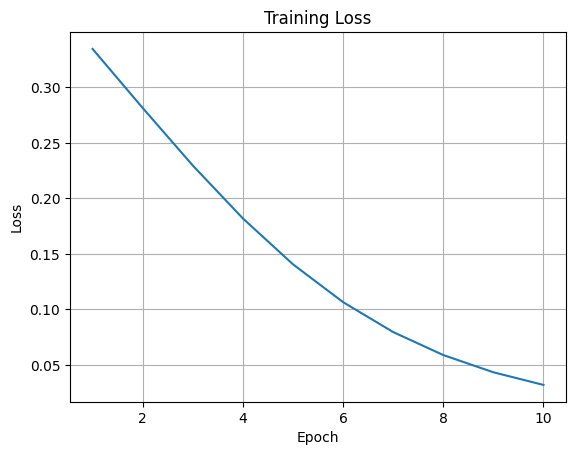

In [4]:
import matplotlib.pyplot as plt

losses = []

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(padded)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Plot loss
plt.plot(range(1, 11), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


In [5]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)  # Multiply hidden size for bidirection

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        # Concatenate forward and backward hidden states
        out = torch.cat((hidden[0], hidden[1]), dim=1)
        return self.fc(out)


In [6]:
# Save
torch.save(model.state_dict(), "sentiment_model.pt")

# Load
loaded_model = SimpleLSTM(len(vocab), 10, 16).to(device)
loaded_model.load_state_dict(torch.load("sentiment_model.pt"))
loaded_model.eval()


SimpleLSTM(
  (embedding): Embedding(9, 10)
  (lstm): LSTM(10, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

In [7]:
!pip install gradio --quiet

import gradio as gr

def gradio_predict(text):
    return predict_sentiment(text, model, vocab)

gr.Interface(fn=gradio_predict, inputs="text", outputs="text", title="Simple Sentiment Classifier").launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://739aeb16315aa872b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
